In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.6f}'.format  

# 그래프에서 한글 깨짐 방지
import platform
if platform.system() == "Darwin":          # MAC인 경우
    plt.rc('font', family ="AppleGothic")
else:
    plt.rc('font',family='Malgun Gothic')

#멧플로립에서 음수를 표시
plt.rc('axes',unicode_minus=False)

#워닝 메시지
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_origin = pd.read_csv('./datasets/원본data.csv',index_col=0)
df=pd.read_csv('./datasets/원본data.csv',index_col=0)


## 1. CORR보고 다중공선성 삭제

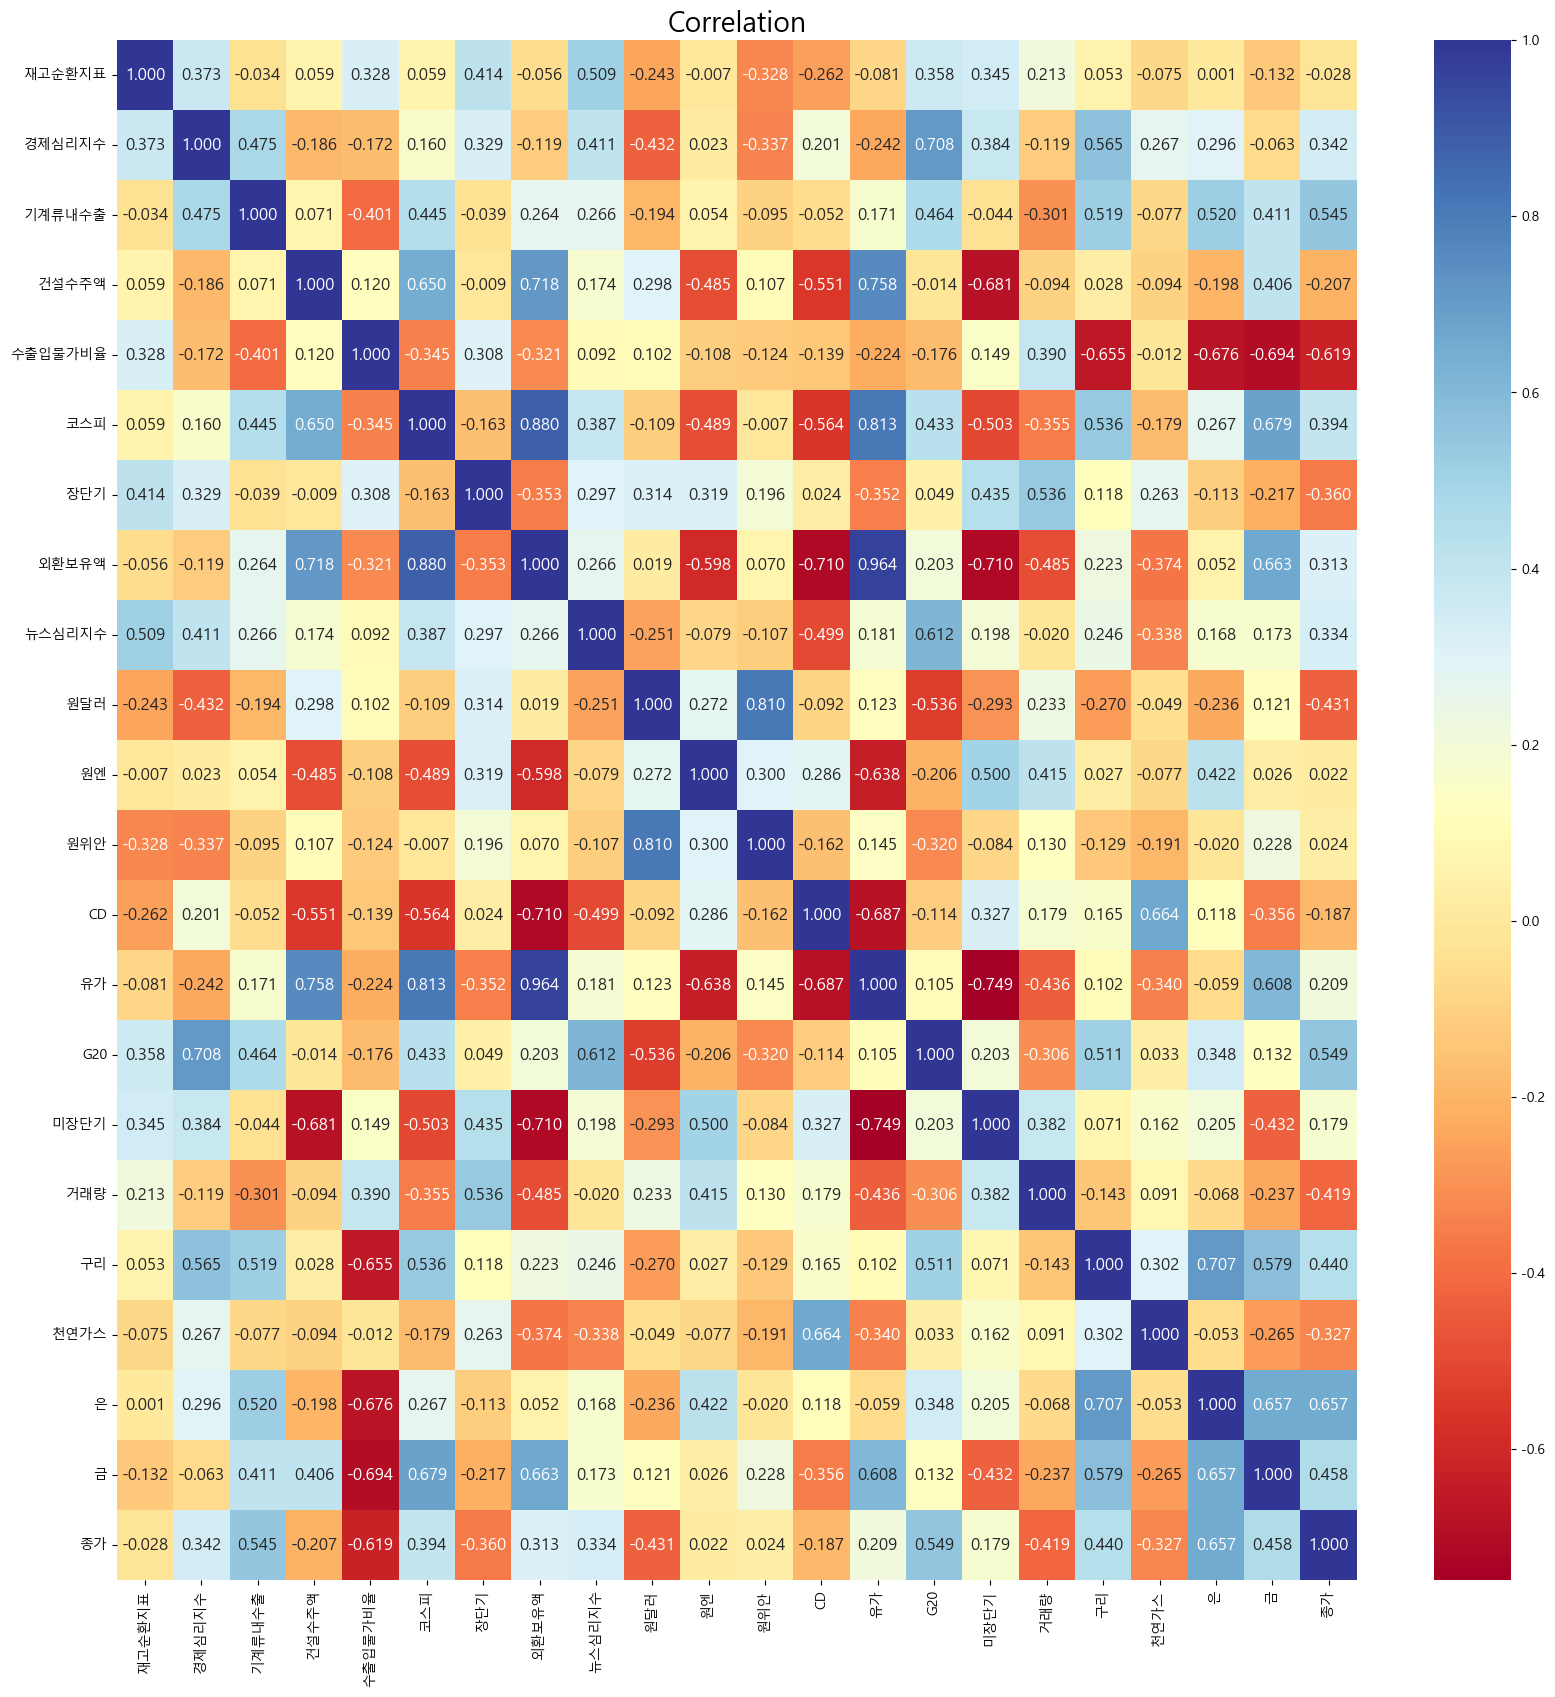

In [3]:
fig,ax= plt.subplots(1,1,figsize=(20,20),sharey=True)

sns.heatmap(df.corr(), annot=True,fmt='.3f' ,annot_kws={'size':12}, cmap="RdYlBu")
plt.title('Correlation', fontsize=20)
plt.show()

In [4]:
df.drop(['유가','은','원위안','외환보유액'],axis=1,inplace=True)

In [5]:
df.columns

Index(['재고순환지표', '경제심리지수', '기계류내수출', '건설수주액', '수출입물가비율', '코스피', '장단기',
       '뉴스심리지수', '원달러', '원엔', 'CD', 'G20', '미장단기', '거래량', '구리', '천연가스', '금',
       '종가'],
      dtype='object')

## 2.VIF를 고려해서 다중공선성 삭제

In [6]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 데이터프레임으로부터 독립변수들을 선택하여 X에 저장
X = df[['재고순환지표', '경제심리지수', '기계류내수출', '건설수주액', '수출입물가비율', '코스피', '장단기',
       '뉴스심리지수', '원달러', '원엔', 'CD', 'G20', '미장단기', '거래량', '구리','천연가스', '금']]

# statsmodels의 상수항을 추가하기 위해 X에 상수 열 추가
X = sm.add_constant(X)

# VIF 계산
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# VIF 결과 출력
print(vif)

    Feature   VIF Factor
0     const 16019.602456
1    재고순환지표     2.201077
2    경제심리지수     4.989933
3    기계류내수출     2.253243
4     건설수주액     5.764982
5   수출입물가비율     6.128624
6       코스피    12.500400
7       장단기     5.496131
8    뉴스심리지수     3.584503
9       원달러     3.648308
10       원엔     4.027063
11       CD     9.173322
12      G20     4.155940
13     미장단기     5.107179
14      거래량     2.933881
15       구리    12.607457
16     천연가스     4.375721
17        금    11.822388


In [7]:
df.drop('구리',axis=1,inplace=True)

## 3. 데이터 전처리

In [8]:
## 경제심리지수, 기계류내수출,수출입물가비율 ,장단기금리차, 외환보유액, 뉴스심리지수, 원달러,G20, 천연가스--> 정상적이다

## G7. G20은 비슷하므로 G7 drop
#df2=df2.drop('G7',axis=1)

df['재고순환지표']+=25
df['재고순환지표']=np.log1p(df['재고순환지표']/df['재고순환지표'].shift(1))
df['건설수주액']=np.log1p(df['건설수주액']/df['건설수주액'].shift(1))
df['코스피']=np.log1p(df['코스피']/df['코스피'].shift(1))
df['원엔']=np.log1p(df['원엔']/df['원엔'].shift(1))
# df['원위안']=np.log1p(df['원위안']/df['원위안'].shift(1))
df['CD']=np.log1p(df['CD']/df['CD'].shift(1))
# df['유가']=np.log1p(df['유가']/df['유가'].shift(1))
df['미장단기']+=0.9
df['미장단기']=np.log1p(df['미장단기']/df['미장단기'].shift(1))
df['거래량']=np.log1p(df['거래량']/df['거래량'].shift(1))
# df['구리']=np.log1p(df['구리']/df['구리'].shift(1))
# df['은']=np.log1p(df['은']/df['은'].shift(1))
df['금']=np.log1p(df['금']/df['금'].shift(1))

df['원달러'] /=1000
df['경제심리지수'] /=100
df['기계류내수출'] /=100
df['수출입물가비율'] /=100
df['뉴스심리지수'] /=100
df['G20']/=100

df['천연가스']/=10

df['종가']=np.log(df['종가']/df['종가'].shift(1))
df=df.dropna(axis=0)


## 4.ADF로 정상성 검정

In [9]:
### H0가 비정상(non-stationary)이다
### 유의수준보다 p-value가 작으면 기각 --> 정상적 데이터다

from statsmodels.tsa.stattools import adfuller
import pandas as pd
pd.options.display.float_format = '{:.6f}'.format

adf_df = pd.DataFrame()  # 빈 데이터프레임 생성

for i in df.columns:
    adf_sample = adfuller(df[i], autolag='AIC')
    
    adf_result = pd.Series(adf_sample[:4], index=['stat', 'p_value', 'lag', 'observ'])
    sig_level = adf_sample[4]['5%']
    adf_result['5%'] = sig_level
    
    adf_df[i] = adf_result  # 결과를 데이터프레임에 열(column)로 추가

adf_df = adf_df.transpose()  # 행(row)과 열(column)을 전환하여 변환
adf_df

,stat,p_value,lag,observ,5%
재고순환지표,-7.304759,0.000000,3.000000,179.000000,-2.877826
경제심리지수,-3.325043,0.013795,11.000000,171.000000,-2.878595
기계류내수출,-3.823751,0.002673,11.000000,171.000000,-2.878595
건설수주액,-3.364965,0.012213,12.000000,170.000000,-2.878696
수출입물가비율,-3.070182,0.028840,13.000000,169.000000,-2.878799
코스피,-4.450479,0.000241,12.000000,170.000000,-2.878696
장단기,-3.516219,0.007580,13.000000,169.000000,-2.878799
뉴스심리지수,-5.616294,0.000001,12.000000,170.000000,-2.878696
원달러,-3.601805,0.005727,0.000000,182.000000,-2.877555
원엔,-6.256354,0.000000,4.000000,178.000000,-2.877918


## 5.GRANGER 인과검정으로 feature 선정

In [10]:
from statsmodels.tsa.stattools import grangercausalitytests
#워닝 메시지
import warnings
warnings.filterwarnings('ignore')

#df.replace(',', '', regex=True, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce') # numeric 변환
maxlag= 6
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=True):

    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            # if verbose:print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            min_p_value_index = np.argmin(p_values)
            df.loc[r, c] = min_p_value
            # print(r,c)
            # print(f'Minimum P-value Index: {min_p_value_index} (Lag: {min_p_value_index + 1})')
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
df_granger=grangers_causation_matrix(df, variables = df.columns)
#df.to_csv('granger검정.csv')
df_granger

,재고순환지표_x,경제심리지수_x,기계류내수출_x,건설수주액_x,수출입물가비율_x,코스피_x,장단기_x,뉴스심리지수_x,원달러_x,원엔_x,CD_x,G20_x,미장단기_x,거래량_x,천연가스_x,금_x,종가_x
재고순환지표_y,1.000000,0.000000,0.014100,0.042800,0.000000,0.000000,0.000000,0.001300,0.000000,0.000000,0.000000,0.015800,0.008600,0.000000,0.143800,0.000000,0.000100
경제심리지수_y,0.000200,1.000000,0.186400,0.106500,0.000300,0.000000,0.000000,0.000000,0.070000,0.000000,0.304000,0.000000,0.290300,0.000200,0.002500,0.022600,0.000000
기계류내수출_y,0.215400,0.001000,1.000000,0.560300,0.016300,0.005200,0.001300,0.000000,0.097500,0.004600,0.071800,0.007900,0.058400,0.173100,0.088700,0.068500,0.000200
건설수주액_y,0.141600,0.248700,0.082800,1.000000,0.188700,0.505100,0.016200,0.472600,0.272300,0.089400,0.368200,0.139000,0.304500,0.390200,0.030200,0.115700,0.489700
수출입물가비율_y,0.019000,0.000000,0.015100,0.054100,1.000000,0.000000,0.000000,0.000000,0.008900,0.003900,0.006900,0.000000,0.431000,0.265600,0.069000,0.037400,0.000000
코스피_y,0.001200,0.000100,0.149900,0.085100,0.000000,1.000000,0.000400,0.000000,0.000100,0.091500,0.010300,0.000000,0.005000,0.233100,0.005800,0.269400,0.000000
장단기_y,0.000000,0.000000,0.000000,0.001700,0.000000,0.004700,1.000000,0.088900,0.002200,0.001000,0.000000,0.000000,0.000000,0.095400,0.005500,0.009400,0.003900
뉴스심리지수_y,0.256600,0.029500,0.450700,0.261300,0.000400,0.199700,0.072000,1.000000,0.024700,0.819200,0.056400,0.001100,0.243600,0.410600,0.002300,0.006700,0.836800
원달러_y,0.000000,0.007200,0.191400,0.201500,0.095100,0.000000,0.000000,0.000000,1.000000,0.018400,0.024200,0.003200,0.081300,0.059900,0.000000,0.373100,0.002800
원엔_y,0.000000,0.003300,0.280300,0.023200,0.006900,0.000100,0.081200,0.000000,0.037700,1.000000,0.095100,0.109200,0.496100,0.127000,0.000200,0.055300,0.485300


In [11]:
df.columns

Index(['재고순환지표', '경제심리지수', '기계류내수출', '건설수주액', '수출입물가비율', '코스피', '장단기',
       '뉴스심리지수', '원달러', '원엔', 'CD', 'G20', '미장단기', '거래량', '천연가스', '금', '종가'],
      dtype='object')

##  ***** granger의 상호 영향(상관관계)--> granger결과 *****
    - 재고순환지표 경제심리지수 수출입물가비율 코스피 장단기 원달러 CD G20 종가

## 6. VAR을 통해 maxlag찾기 ->2,5 

In [12]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

model_var = VAR(endog=df[['재고순환지표','경제심리지수','수출입물가비율','코스피','장단기','원달러','CD','G20','종가']])            
res = model_var.select_order(6)            
res.summary()

,AIC,BIC,FPE,HQIC
0,-49.98,-49.82,1.973e-22,-49.91
1,-64.96,-63.35,6.120e-29,-64.31
2,-67.32,-64.25*,5.829e-30,-66.08*
3,-67.76,-63.24,3.809e-30,-65.93
4,-67.92,-61.95,3.359e-30,-65.50
5,-68.23*,-60.80,2.600e-30*,-65.22
6,-68.19,-59.31,2.932e-30,-64.59


## 7.VAR모델로 모델링 !!!
    - train,test로 나누기 --> test를 36개로

In [13]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

# train 데이터 프레임 정의
train_data = df.iloc[:147][['재고순환지표','경제심리지수','수출입물가비율','코스피','장단기','원달러','CD','G20','종가']]
train = pd.DataFrame(train_data)
                           
# test 데이터 프레임 정의
test_data = df.iloc[147:][['재고순환지표','경제심리지수','수출입물가비율','코스피','장단기','원달러','CD','G20','종가']]
test = pd.DataFrame(test_data)
print(len(train),len(test))

# Initialize empty DataFrame to store predictions
pred = pd.DataFrame(columns=train.columns)

for t in range(len(test)):
    # Fit VAR model with constant
    model_var = VAR(endog=train)
    model_fit = model_var.fit(maxlags=2, ic='hqic', trend='c')

    # One step forecast
    forecast = model_fit.forecast(train.values[-2:], steps=1)

    # Append the prediction to pred DataFrame
    pred = pd.concat([pred, pd.DataFrame(forecast, columns=pred.columns)], ignore_index=True)

    # Append the current test observation to train DataFrame for the next training
    train = pd.concat([train, test.iloc[[t]]], ignore_index=True)

pred.reset_index(drop=True, inplace=True)


147 36


In [14]:
pred

,재고순환지표,경제심리지수,수출입물가비율,코스피,장단기,원달러,CD,G20,종가
0,1.032049,0.545463,1.004673,0.629637,0.588321,1.340245,0.570036,0.862367,-0.172017
1,1.161396,0.613407,0.981073,0.712510,0.879468,1.341804,0.499501,0.908559,-0.064068
2,1.713040,0.707121,0.938933,0.745001,0.883598,1.222923,0.576612,0.983274,0.131732
3,1.093001,0.771169,0.936059,0.718398,0.603034,1.155829,0.651446,0.989371,0.016786
4,0.811451,0.836459,0.948711,0.719329,0.650101,1.119995,0.677936,0.996609,0.051659
5,1.170147,0.829399,0.970395,0.700133,0.722043,1.171737,0.656201,0.996271,-0.109003
6,0.876955,0.863752,0.972863,0.698465,0.690372,1.166132,0.691349,0.999918,-0.058545
7,0.763260,0.889805,0.966735,0.700331,0.754799,1.116457,0.687827,1.004811,0.028292
8,0.750340,0.926222,0.951280,0.720796,0.784729,1.045713,0.688067,1.010340,0.089120
9,0.721378,0.928201,0.932733,0.732233,0.909167,1.026928,0.694176,1.013959,0.064963


## 8.예측값을 데이터프레임으로

In [15]:
pred['date']= test.index
pred=pred.set_index('date')
show=pd.concat([pred['종가'],test['종가']], axis=1, keys=['예측', '실제'])
a=df_origin[148:][['종가']]
show=pd.concat([show,a],axis=1).rename(columns={'종가':'실제종가'})
b=df_origin[147:]['종가'] * np.exp(show['예측'])
b=b.dropna()
show=pd.concat([show,b],axis=1)
show.rename(columns={0 : '예측종가'},inplace=True)
show

,예측,실제,실제종가,예측종가
2020-05,-0.172017,0.116203,1047.710000,882.134581
2020-06,-0.064068,0.098670,1156.360000,1084.598105
2020-07,0.131732,-0.033584,1118.170000,1275.611035
2020-08,0.016786,0.081749,1213.420000,1233.959921
2020-09,0.051659,0.160504,1424.680000,1500.211939
2020-10,-0.109003,0.030546,1468.870000,1317.176433
2020-11,-0.058545,-0.035161,1418.120000,1337.479199
2020-12,0.028292,0.096859,1562.350000,1607.183327
2021-01,0.089120,0.102901,1731.680000,1893.093402
2021-02,0.064963,0.124357,1960.990000,2092.611453


In [16]:
# print(model_fit.summary())

## 9.시각화

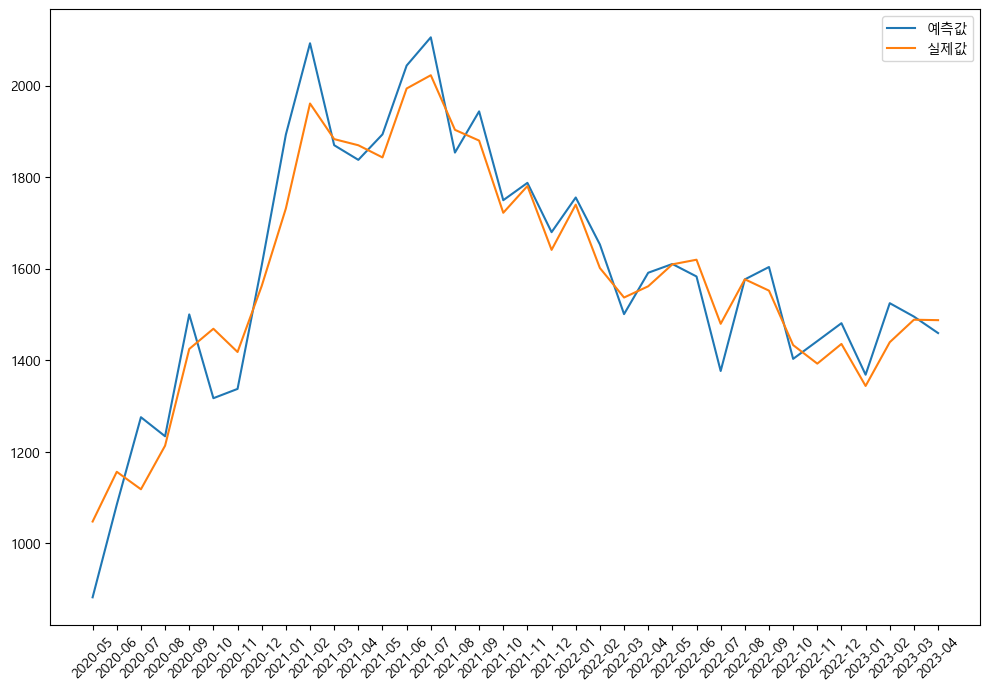

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

plt.plot(show.index, show['예측종가'],label='예측값')
plt.plot(show.index, show['실제종가'],label='실제값')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## 10.평가지표로 확인

In [18]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

#Calculate mean absolute error
mae = mean_absolute_error(show['실제종가'],show['예측종가'])
print('MAE: %f' % mae)

#Calculate mean squared error and root mean squared error
mse = mean_squared_error(show['실제종가'], show['예측종가'])
print('MSE: %f' % mse)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)

#Calculate mean_absolute_percentage_error
mape = mean_absolute_percentage_error(show['실제종가'],show['예측종가'])
print('MAPE: %f' % mape)

MAE: 57.527033
MSE: 5392.893311
RMSE: 73.436321
MAPE: 0.038883


## 11.모델검정

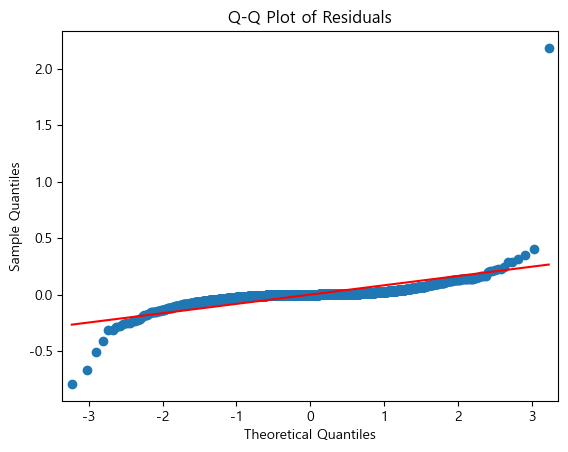

Normality test statistic: 4.092244804995481
p-value: 0.12923505479426498


In [37]:
from scipy.stats import normaltest

# Residuals
residuals = model_fit.resid

residuals_final =model_fit.resid['종가']

# Residual analysis


# Q-Q Plot
sm.qqplot(residuals.values.flatten(), line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

# 잔차의 정규성 검정
statistic, p_value = normaltest(residuals_final.values.flatten())

print("Normality test statistic:", statistic)
print("p-value:", p_value)


In [20]:
for i in residuals.columns:
    statistic, p_value = normaltest(residuals[i].values.flatten())
    print(i)
    print("Normality test statistic:", statistic)
    print("p-value:", p_value)
        
    


    


재고순환지표
Normality test statistic: 221.6106161655335
p-value: 7.548595156355526e-49
경제심리지수
Normality test statistic: 16.43124471906451
p-value: 0.00027039617501982573
수출입물가비율
Normality test statistic: 3.3868186705427488
p-value: 0.18389150624143552
코스피
Normality test statistic: 6.128615126501791
p-value: 0.046686157886174785
장단기
Normality test statistic: 16.687980226394544
p-value: 0.0002378215124823548
원달러
Normality test statistic: 21.348505116446038
p-value: 2.313294980658743e-05
CD
Normality test statistic: 35.46489083433018
p-value: 1.9902003793089736e-08
G20
Normality test statistic: 173.52211510761907
p-value: 2.09002490038217e-38
종가
Normality test statistic: 4.092244804995481
p-value: 0.12923505479426498


In [21]:
# from scipy.stats import jarque_bera
import numpy as np
from scipy.stats import jarque_bera


# Jarque-Bera 정규성 검정 수행
jb_value, p_value = jarque_bera(residuals_final)

# 검정 통계량과 p-value 출력 (소수점 6번째 자리까지)
print("Jarque-Bera 검정 통계량: {:.6f}".format(jb_value))
print("p-value: {:.6f}".format(p_value))


Jarque-Bera 검정 통계량: 3.794679
p-value: 0.149967


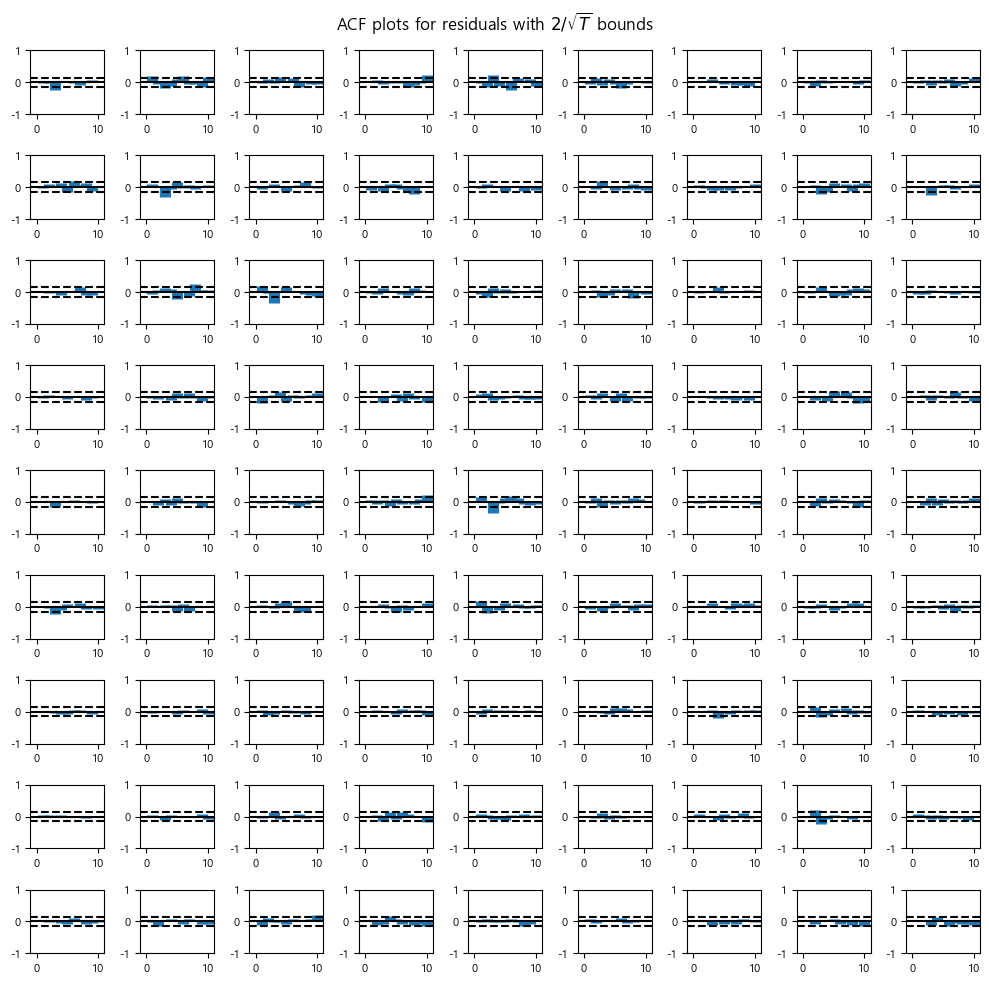

In [22]:
# 잔차진단
model_fit.plot_acorr()
plt.tight_layout()
plt.show()

### durbin_watson--> 잔차의 독립성 검정!

In [23]:
residuals

,재고순환지표,경제심리지수,수출입물가비율,코스피,장단기,원달러,CD,G20,종가
2,-0.004117,0.006333,-0.005477,0.016788,-0.050327,-0.001289,0.029101,-0.000059,0.072053
3,0.061708,-0.019908,-0.003567,0.005841,0.101023,0.022512,-0.010282,-0.003918,0.043916
4,-0.075836,0.000300,0.000095,0.005248,0.040640,0.004454,-0.014565,-0.002330,0.031982
5,-0.051228,-0.021428,-0.005985,-0.016205,0.138348,-0.005027,-0.008607,-0.003411,-0.056516
6,-0.154329,0.030310,0.006425,-0.004263,-0.180127,-0.085528,0.027595,-0.001489,0.067339
...,...,...,...,...,...,...,...,...,...
177,0.040229,-0.022149,0.000834,0.000182,-0.028929,0.040394,0.065864,0.000604,-0.051572
178,-0.035481,-0.009789,0.007195,-0.001761,-0.254089,-0.061307,-0.020573,0.000765,0.007517
179,-0.275360,-0.005837,0.002993,0.000850,-0.046819,-0.018095,-0.011586,-0.000087,-0.067970
180,-0.056263,0.010718,-0.000772,-0.010745,0.016696,-0.009348,-0.043062,-0.002888,0.006694


In [24]:
residuals.corr()

,재고순환지표,경제심리지수,수출입물가비율,코스피,장단기,원달러,CD,G20,종가
재고순환지표,1.000000,0.051350,0.011208,-0.091449,0.096229,0.166613,-0.174783,-0.090766,-0.074646
경제심리지수,0.051350,1.000000,-0.285321,0.328057,-0.089867,-0.292410,0.029509,0.375692,0.288315
수출입물가비율,0.011208,-0.285321,1.000000,-0.392146,-0.146339,0.296669,-0.022444,-0.385194,-0.228421
코스피,-0.091449,0.328057,-0.392146,1.000000,-0.030406,-0.299711,-0.057116,0.226371,0.475408
장단기,0.096229,-0.089867,-0.146339,-0.030406,1.000000,0.116812,-0.148825,-0.040706,-0.180057
원달러,0.166613,-0.292410,0.296669,-0.299711,0.116812,1.000000,0.073428,-0.148576,-0.210629
CD,-0.174783,0.029509,-0.022444,-0.057116,-0.148825,0.073428,1.000000,0.262782,0.011218
G20,-0.090766,0.375692,-0.385194,0.226371,-0.040706,-0.148576,0.262782,1.000000,0.290316
종가,-0.074646,0.288315,-0.228421,0.475408,-0.180057,-0.210629,0.011218,0.290316,1.000000


#### lag=1일때

In [25]:
from statsmodels.stats.stattools import durbin_watson

durbin_res1 = pd.DataFrame([model_fit.resid.columns, 
                           [round(x,2) for x in durbin_watson(model_fit.resid)]]).T
durbin_res1.set_index([0],inplace=True)
durbin_res1.index.name = 'Variable'
durbin_res1.columns=['Durbin-Watson (lag 1)']
durbin_res1


,Durbin-Watson (lag 1)
Variable,
재고순환지표,2.020000
경제심리지수,1.810000
수출입물가비율,1.630000
코스피,1.890000
장단기,1.700000
원달러,2.090000
CD,1.980000
G20,2.020000
종가,1.910000


#### lag=2일때

In [26]:
def cal_dw_stat(res, lag):
    n = len(res)
    a = np.zeros(n)
    a[0] = -1
    a[lag] = 1
    a = np.expand_dims(a, axis=1)
    for i in range(n-lag-1):
        temp = np.zeros(n)
        temp[i+1] = -1
        temp[i+1+lag] = 1
        temp = np.expand_dims(temp, axis=1)
        a = np.concatenate([a, temp], axis=1)

    H = a.dot(a.T)
    dw_stat = res.dot(H.dot(res)) / np.sum(np.square(res - np.mean(res)))
    return dw_stat

dw_values = []
for col in model_fit.resid.columns:
    dw_value = cal_dw_stat(model_fit.resid[col].values.flatten(), lag=2)
    dw_values.append(dw_value)

durbin_res = pd.DataFrame({'Durbin-Watson (lag 2)': dw_values}, index=model_fit.resid.columns)
durbin_res.index.name = 'Variable'
durbin_res


,Durbin-Watson (lag 2)
Variable,
재고순환지표,2.060793
경제심리지수,1.982871
수출입물가비율,2.019351
코스피,1.872378
장단기,1.897916
원달러,1.925787
CD,1.977163
G20,1.614260
종가,1.894338


In [27]:
Durbin_Watson_resid=pd.concat([durbin_res1,durbin_res], axis=1)
Durbin_Watson_resid

,Durbin-Watson (lag 1),Durbin-Watson (lag 2)
Variable,,
재고순환지표,2.020000,2.060793
경제심리지수,1.810000,1.982871
수출입물가비율,1.630000,2.019351
코스피,1.890000,1.872378
장단기,1.700000,1.897916
원달러,2.090000,1.925787
CD,1.980000,1.977163
G20,2.020000,1.614260
종가,1.910000,1.894338


#### 잔차의 residplot

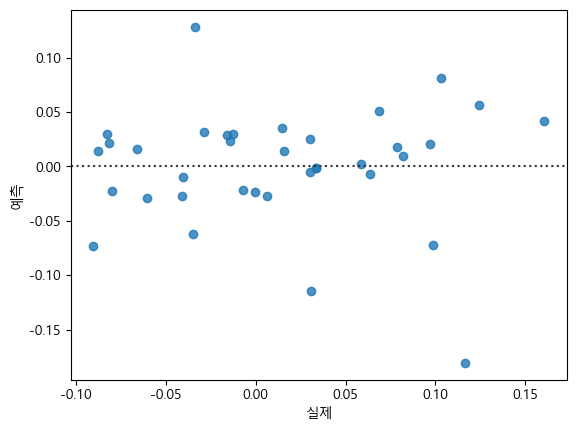

In [28]:
import seaborn as sns

sns.residplot(x=show['실제'],y= show['예측'])
plt.show()

#### 잔차의 평균

In [29]:
np.mean(residuals)

4.66019541200683e-16

## 12.최종 데이터 그래프(train + test)

In [30]:
df_origin_gr=df_origin.iloc[:149][['재고순환지표','경제심리지수','수출입물가비율','코스피','장단기','원달러','CD','G20','구리','종가']]

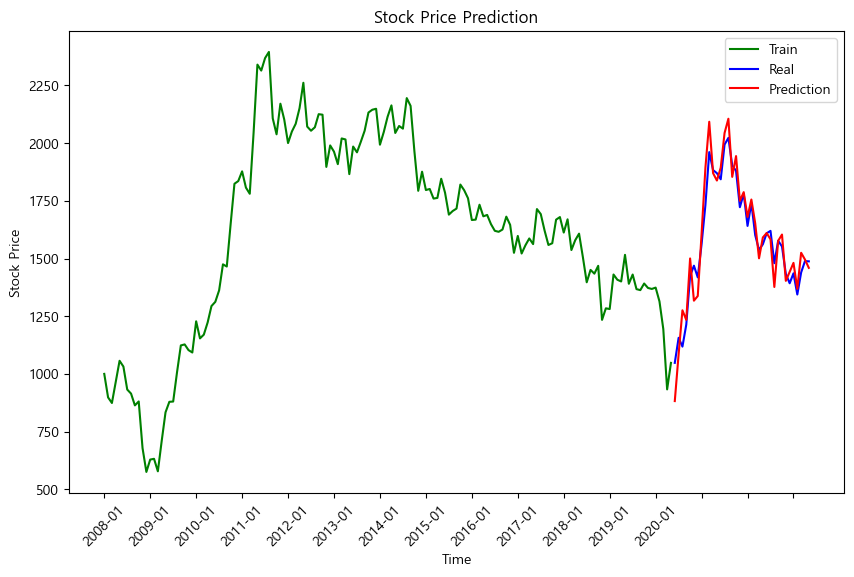

In [31]:
plt.figure(figsize=(10,6))
# Add the training set to the plot:
plt.plot(df_origin_gr['종가'], color='green', label='Train')
# Plot the test and prediction data:
plt.plot(range(len(df_origin_gr['종가']), len(df_origin_gr['종가'])+len(show['실제종가'])), show['실제종가'], color='blue', label='Real')
plt.plot(range(len(df_origin_gr['종가']), len(df_origin_gr['종가'])+len(show['실제종가'])), show['예측종가'], color='red', label='Prediction')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(range(0, len(df_origin_gr['종가'])+len(show['실제종가']), 12), rotation=45)
plt.legend()
plt.show()

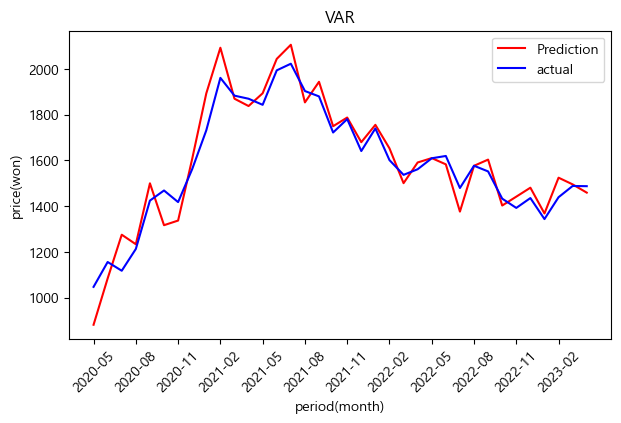

In [32]:
plt.figure(figsize=(7,4))
plt.title('VAR')
plt.ylabel('price(won)')
plt.xlabel('period(month)')
plt.plot(show['예측종가'], label='Prediction', color='r')
plt.plot(show['실제종가'], label='actual', color='b')
plt.legend(loc='best')
plt.xticks(range(0, len(show), 3), rotation=45)  # 인덱스를 6개마다 표시
plt.show()


# VAR모델 최종설명
    1. corr,viff로 다중공선성 제거
    2. 전처리
    3. adf로 정상성 확보
    4. granger로 인과검정 -- > 피쳐선정
    5. VAR이용해서 maxlag찾고 모델링
    6. 모델의 강건성 확인 
        - 잔차의 독립성(darbin watson검정)
        - 등분산성(residplot)
        - 평균 0 
        - 즉 백색소음
    7. 시각화 및 예측

In [33]:
show

,예측,실제,실제종가,예측종가
2020-05,-0.172017,0.116203,1047.710000,882.134581
2020-06,-0.064068,0.098670,1156.360000,1084.598105
2020-07,0.131732,-0.033584,1118.170000,1275.611035
2020-08,0.016786,0.081749,1213.420000,1233.959921
2020-09,0.051659,0.160504,1424.680000,1500.211939
2020-10,-0.109003,0.030546,1468.870000,1317.176433
2020-11,-0.058545,-0.035161,1418.120000,1337.479199
2020-12,0.028292,0.096859,1562.350000,1607.183327
2021-01,0.089120,0.102901,1731.680000,1893.093402
2021-02,0.064963,0.124357,1960.990000,2092.611453


In [34]:
pred = pd.Series(show['예측종가'].values.flatten()).pct_change()
test = pd.Series(show['실제종가'].values.flatten()).pct_change()

In [35]:
re = 1
for i in range(len(pred)):
  if pred[i] > 0:
    re *= (1+test[i])

In [36]:
re

2.3093633245479546